# **DATA PROCESSING**

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [2]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_UG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_UG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/Colab Notebooks/CW_Folder_UG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'Code', 'Models', 'CW_Dataset', 'Personal_Dataset', 'test_functions.ipynb']


# Loading the Dataset, Augmenting and Enhancing images

In [3]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import joblib
from PIL import Image, ImageEnhance
from torchvision import transforms
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from skimage import color, img_as_ubyte
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics

In [4]:
# Load the dataset
def load_dataset(root_dir, subfolder='train'):
    img_dir = os.path.join(root_dir, subfolder, 'images')
    labels_dir = os.path.join(root_dir, subfolder, 'labels')
    img_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith(('.jpg', '.jpeg', '.png'))]
    images, labels = [], []
    for img_name in img_names:
        img_path = os.path.join(img_dir, img_name)
        label_path = os.path.join(labels_dir, os.path.splitext(img_name)[0] + '.txt')
        image = Image.open(img_path).convert('RGB').resize((224, 224), Image.Resampling.LANCZOS)  # Basic resizing for all images
        label = int(open(label_path, 'r').read().strip())
        images.append(image)
        labels.append(label)
    return images, labels

# Enhancement and augmentation functions
def enhance_image(image):
    enhancer_contrast = ImageEnhance.Contrast(image)
    image = enhancer_contrast.enhance(1.8)
    enhancer_brightness = ImageEnhance.Brightness(image)
    image = enhancer_brightness.enhance(1.2)
    return image

augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
])

def apply_augmentations(images):
    return [augmentation_transform(image) for image in images]

root_dir = '/content/drive/MyDrive/Colab Notebooks/CW_Folder_UG/CW_Dataset'
images, labels = load_dataset(root_dir, 'train')

# Split data first
X_train_raw, X_test_raw, y_train, y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, stratify=labels)

# Apply enhancement and augmentation only to training data
X_train = [enhance_image(image) for image in X_train_raw]
X_train = apply_augmentations(X_train_raw)

# Convert images to numpy arrays for model input
X_train = np.array([np.array(img) for img in X_train])
X_test = np.array([np.array(img) for img in X_test_raw])

# Address class imbalance only for the training set
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

# Reshape back to original dimensions
X_train_res= X_train_res.reshape(-1, 224, 224, 3)
# Convert numpy arrays back to PIL Images if necessary for processing
X_train_res = [Image.fromarray(img.astype('uint8'), 'RGB') for img in X_train_res]


print(f"Original dataset shape: {Counter(labels)}")
print(f"Resampled training set shape: {Counter(y_train_res)}")


Original dataset shape: Counter({1: 1940, 0: 376, 2: 78})
Resampled training set shape: Counter({1: 1552, 0: 1552, 2: 1552})


###Visualisation of the Dataset

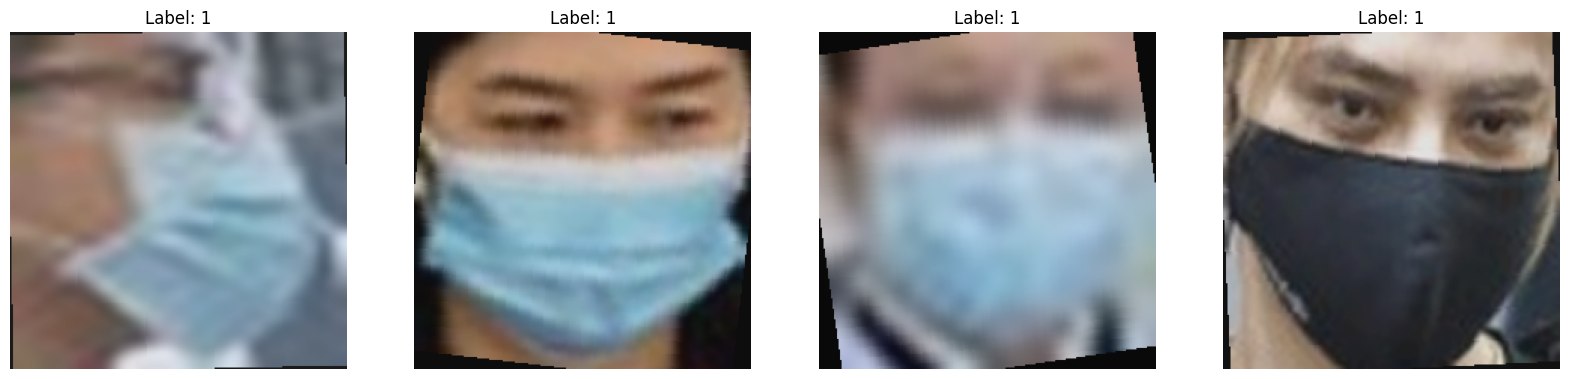

In [5]:
# Visualizing images
def visualize_random_images(images, labels, num_images=4):
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))
    selected_indices = random.sample(range(len(images)), num_images)

    for i, idx in enumerate(selected_indices):
        image = images[idx]
        label = labels[idx]
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

# Visualize random images from the training dataset
visualize_random_images(X_train, y_train)


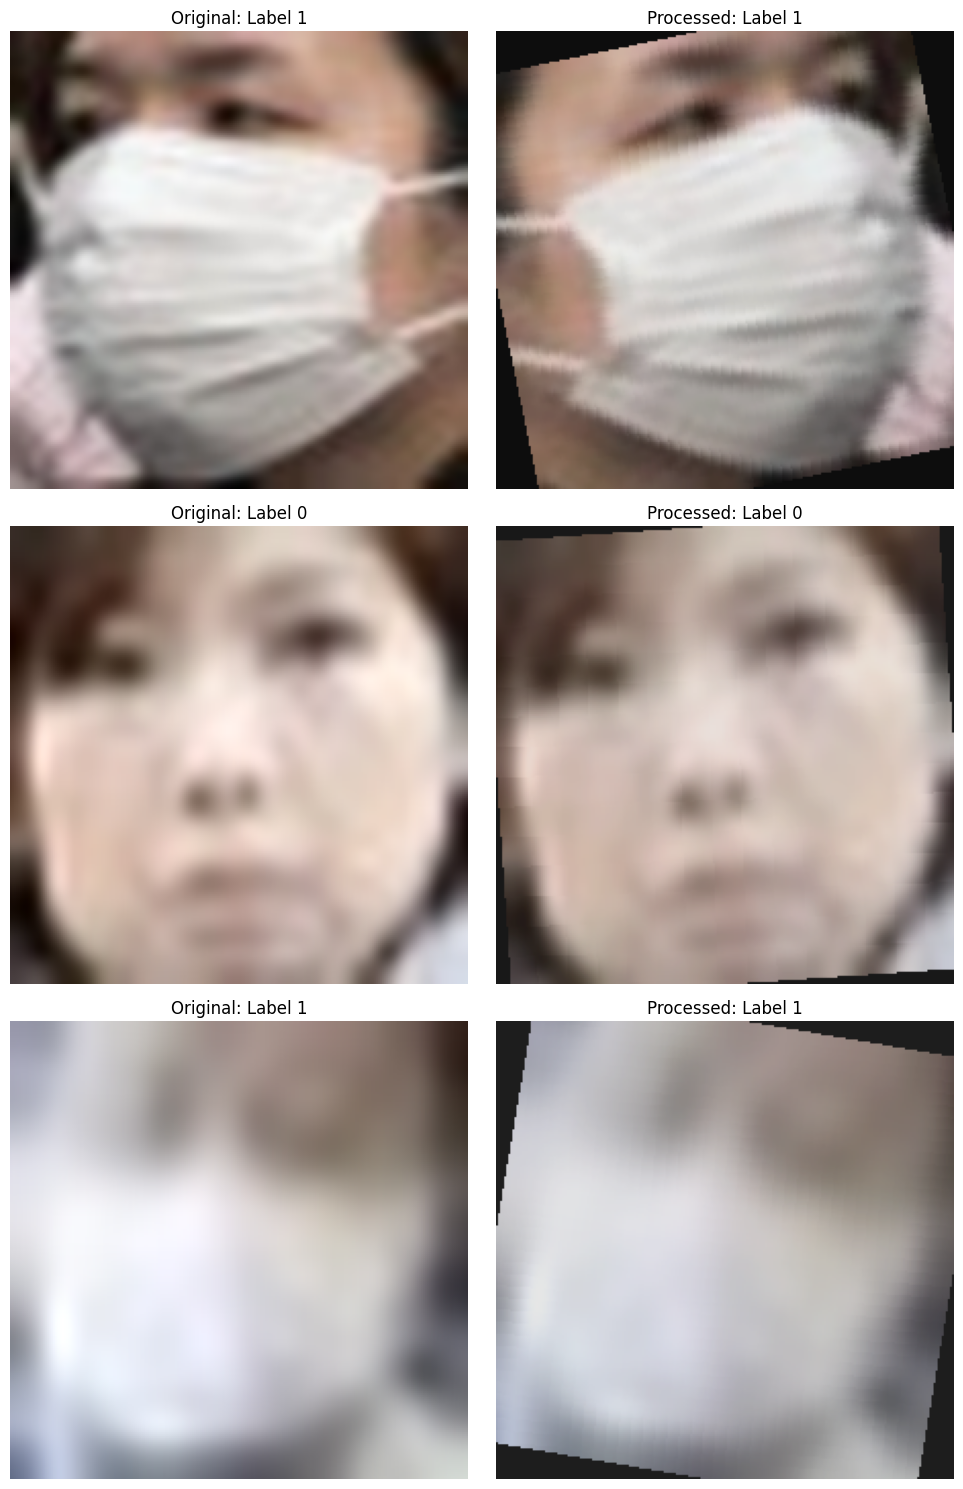

In [6]:
# Visualising the enhancemnt on the images
def visualize_improvements(original_images, processed_images, labels, num_images=3):
    fig, axs = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
    idx_list = random.sample(range(len(original_images)), num_images)

    for row, idx in enumerate(idx_list):
        original_image = np.array(original_images[idx])
        processed_image = processed_images[idx]

        label = labels[idx]

        # Plot the original and processed images
        axs[row, 0].imshow(original_image)
        axs[row, 0].set_title(f"Original: Label {label}")
        axs[row, 1].imshow(processed_image)
        axs[row, 1].set_title(f"Processed: Label {label}")
        for ax in axs[row]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()
X_train_res, y_train_res
visualize_improvements(X_train_raw, X_train, y_train, num_images=3)

# SIFT


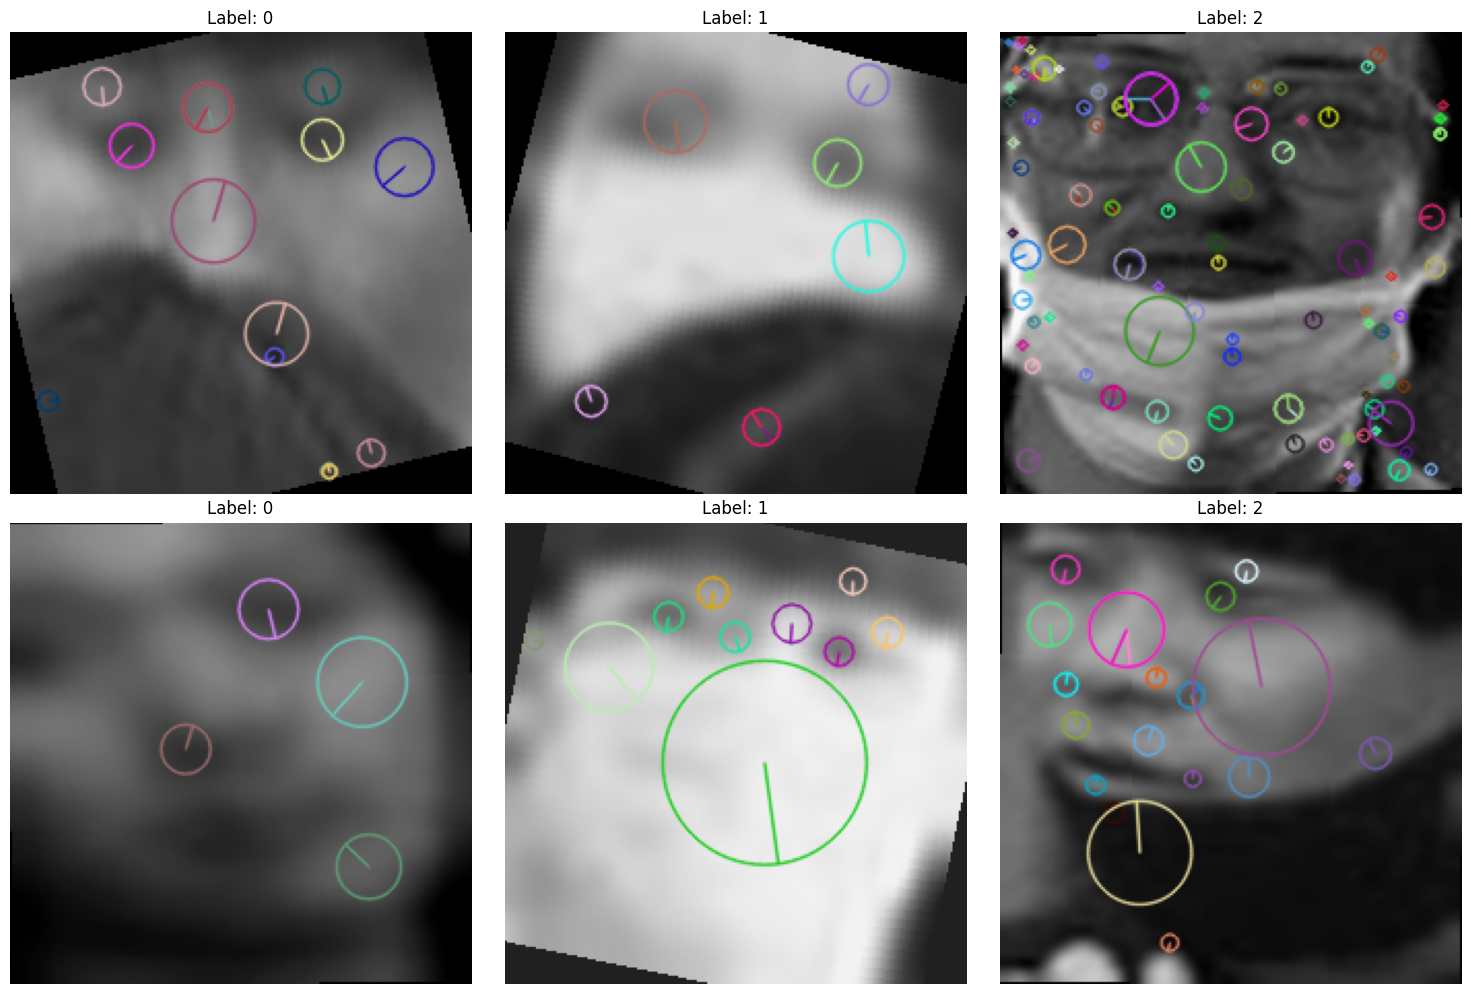

In [7]:
# Initiate SIFT detector and empty lists for feature descriptors and labels
sift = cv2.SIFT_create()
des_list = []
y_list = []

# Prepare subplot structure for visualizing SIFT keypoints
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

images_shown = {0: 0, 1: 0, 2: 0}  # Track how many images have been shown per category

for image, label in zip(X_train_res, y_train_res):
    # Convert PIL Image to numpy array and grayscale
    img_np = np.array(image)
    img_gray = img_as_ubyte(color.rgb2gray(img_np))

    kp, des = sift.detectAndCompute(img_gray, None)

    # Check if showns less than 2 images for the current label
    if images_shown[label] < 2:
        subplot_idx = 3 * images_shown[label] + label
        ax = axes[subplot_idx]
        img_with_keypoints = cv2.drawKeypoints(img_gray, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        ax.imshow(img_with_keypoints, cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')

        images_shown[label] += 1

    # Store the descriptors and labels
    if des is not None:
        des_list.append(des)
        y_list.append(label)

plt.tight_layout()
plt.show()


### Feature Matrix

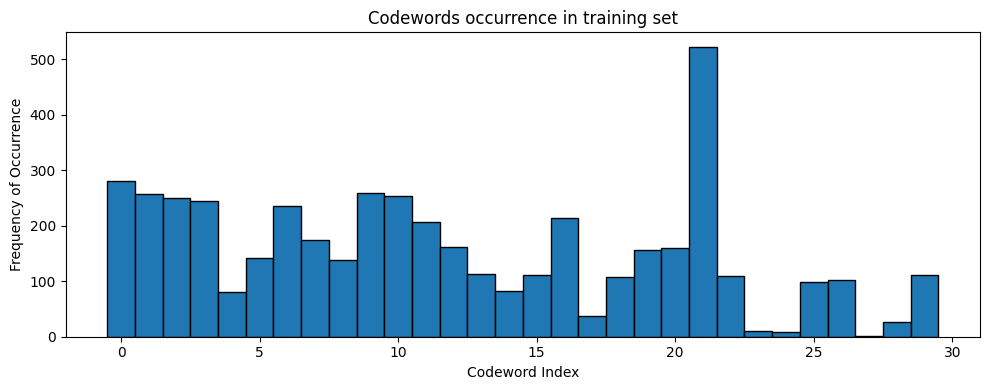

In [8]:
# Flatten the list of descriptors to fit KMeans
des_array = np.vstack(des_list)

# Determine the number of clusters k
num_classes = len(np.unique(y_list))
k = num_classes * 10

# Use MiniBatchKMeans for clustering
batch_size = max(des_array.shape[0] // 4, 1)  # Ensure batch_size is at least 1 for stability
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init=10).fit(des_array)

# Convert descriptors into histograms of codewords for each image
hist_list = []
for des in des_list:
    hist = np.zeros(k)
    idx = kmeans.predict(des)
    for j in idx:
        hist[j] += 1 / len(des)  # Normalizing by the number of keypoints to make histograms comparable
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

# Plotting overall histogram for the codewords occurrence in the training set
fig, ax = plt.subplots(figsize=(10, 4))
# Flatten the histogram array to get a distribution of codeword occurrences across all images
all_idxs = np.argmax(hist_array, axis=1)
ax.hist(all_idxs, bins=range(k+1), edgecolor='black', align='left')  # Ensure bins correspond to codeword indices
ax.set_title('Codewords occurrence in training set')
plt.xlabel('Codeword Index')
plt.ylabel('Frequency of Occurrence')
plt.tight_layout()
plt.show()


# SVM

In [9]:
# Create a classifier: a support vector classifier with radial basis function kernel
classifier = svm.SVC(kernel='rbf')

# Fit the classifier on the training data
classifier.fit(hist_array, y_list)


SVC()

In [10]:
hist_list = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_test = [y_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

In [11]:
y_pred = classifier.predict(hist_array).tolist()

In [12]:
print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_test, y_pred)}\n""")

Classification report for classifier SVC():
                    precision    recall  f1-score   support

           0       0.28      0.51      0.36        75
           1       0.88      0.68      0.76       388
           2       0.05      0.12      0.07        16

    accuracy                           0.63       479
   macro avg       0.40      0.44      0.40       479
weighted avg       0.76      0.63      0.68       479




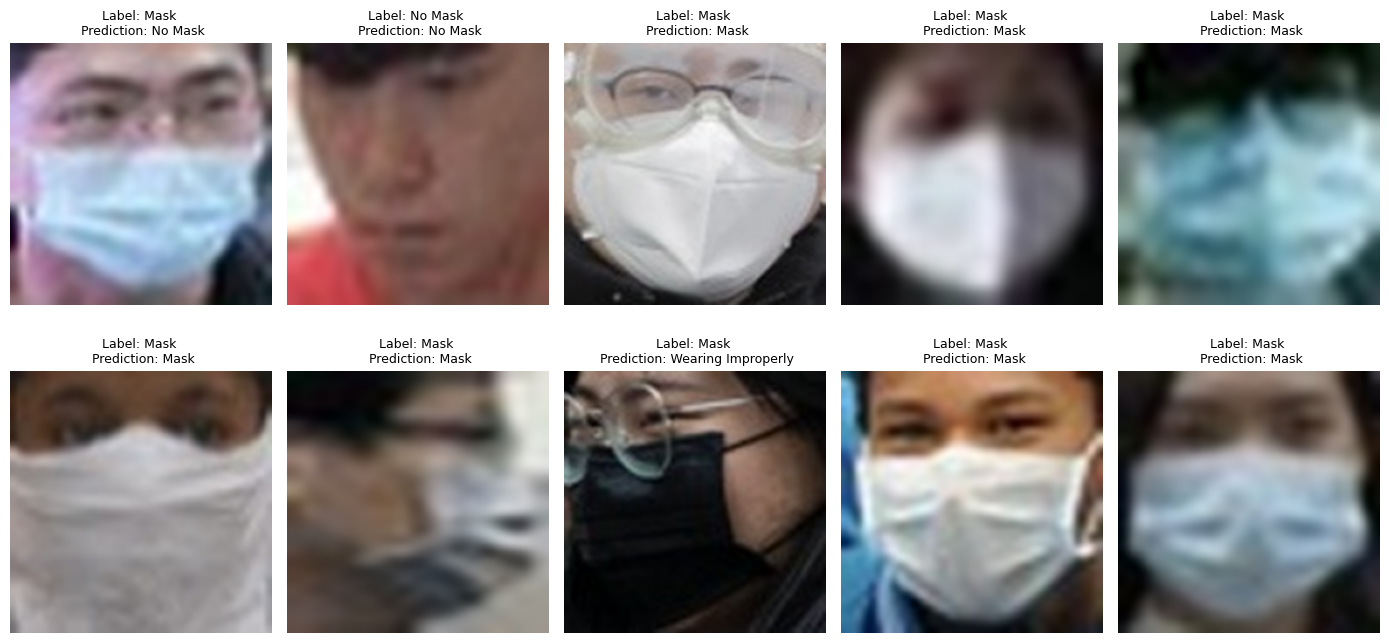

In [13]:
# Mapping of numerical labels to descriptive
label_map = {0: 'No Mask', 1: 'Mask', 2: 'Wearing Improperly'}

fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(10):  # Displaying the first 10 images
    img_np = np.array(X_test[i])  # Convert PIL Image to numpy array
    ax = axes[i]
    ax.imshow(img_np)

    # Get the descriptive labels
    true_label = label_map[y_test[i]]
    pred_label = label_map[y_pred[i]]

    ax.set_title(f'Label: {true_label} \n Prediction: {pred_label}', fontsize=9)
    ax.axis('off')

fig.tight_layout()
plt.show()


# Saving the Model

In [14]:
# Directory where the model will be saved
model_dir = '/content/drive/MyDrive/Colab Notebooks/CW_Folder_UG/Models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Path to save the model file
model_path = os.path.join(model_dir, 'SIFT_SVM_model.pkl')

# Save the SVM model
joblib.dump(classifier, model_path)

print(f"Model saved successfully at {model_path}")


Model saved successfully at /content/drive/MyDrive/Colab Notebooks/CW_Folder_UG/Models/SIFT_SVM_model.pkl


In [15]:
# Path to save the kmeans model
kmeans_model_path = os.path.join(model_dir, 'SIFT_KMeans_model.pkl')

# Save the kmeans model
joblib.dump(kmeans, kmeans_model_path)

print(f"kmeans model saved successfully at {kmeans_model_path}")


kmeans model saved successfully at /content/drive/MyDrive/Colab Notebooks/CW_Folder_UG/Models/SIFT_KMeans_model.pkl
